# Импорты и классы

In [77]:
import os
import matplotlib.pyplot as plt
import pathlib
from dotenv import load_dotenv, dotenv_values
load_dotenv() 
device = os.environ['DEVICE']
from pager import PDFModel, RegionModel, RowsModel, PDF2Words, PDF2Rows, ImageModel, PDF2Img

import numpy as np
from pager.page_model.sub_models.dtype import ImageSegment 
from pager.page_model.sub_models.phisical_model.segment_clusterizer import KMeanClusterizer
from pager.page_model.sub_models import BaseConverter
from pager.page_model.sub_models.dtype import Graph
import re
import torch
from torch.nn import Linear, BCELoss, BCEWithLogitsLoss, CrossEntropyLoss, GELU, HuberLoss,ModuleList
from torch.nn.functional import relu
from torch_geometric.nn import BatchNorm, TAGConv
from typing import List

from json import JSONEncoder  
from torch.utils.data import Dataset 
import json
import torch
import os

from torch.utils.data import Dataset 
import json

import time
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt

dataset_path = os.environ['DATASER_PATH']
test_path = os.environ['TEST_PATH']
test_coco_path = os.environ['TEST_COCO_PATH']
coco_path = os.environ['COCO_PATH']
cash_path = os.environ['CASH_PATH']

SAVE_FREQUENCY = 5
LOG_FILE = 'log.txt'

def log(str_):
    with open(LOG_FILE, 'a') as f:
        f.write(str_+'\n')


GLAM_MODEL = 'row2region_GLAM'
PARAMS  = {
    "node_featch": 15,
    "edge_featch": 4,
    "epochs": 20,
    "batch_size": 50,
    "learning_rate": 0.05,
    "Tag":[ {'in': -1, 'size': 128, 'out': 64, 'k': 3},
            {'in': 64, 'size': 64, 'out': 32, 'k': 2},
            {'in': 32, 'size': 32, 'out': 16, 'k': 1},
            ],
    "NodeLinear": [-1, 16],
    "NodeLinearClassifier": [8],
    "EdgeLinear": [32, 8],
    "NodeClasses": 5,
    "batchNormNode": True,
    "batchNormEdge": True,
    "seg_k": 0.5,
    "loss_params": {
        "publaynet_imbalance": [0.035, 0.107, 0.428, 0.214, 0.214],
        "edge_imbalance": 1.87,
        "edge_coef": 1,
        "node_coef": 0.25,
    },
    "sigmoidEdge": False
}

In [78]:
PUBLAYNET = 'publaynet'
DOCLAYNET = 'doclaynet'

NAME_DATASET = PUBLAYNET

## Токенизатор

In [79]:
def graph_creat(segments):
    def fun_dist_bottom(seg1: ImageSegment, seg: ImageSegment):
        b = seg1.y_bottom_right
        t = seg.y_top_left
        if seg1.x_bottom_right < seg.x_top_left or seg.x_bottom_right < seg1.x_top_left:
            return np.inf
        if b >= t:
            return np.inf
        return t - b

    def fun_dist_right(seg1: ImageSegment, seg: ImageSegment):
        r = seg1.x_bottom_right
        l = seg.x_top_left

        _, y1c = seg1.get_center()
        _, yc = seg.get_center()
        h = (seg1.height + seg.height)/2        
        if seg1.y_bottom_right - seg.y_top_left >  3*h or seg.y_bottom_right - seg1.y_top_left > 3*h:
            return np.inf
        if r >= l:
            return np.inf
        return abs(l - r)+5*abs(y1c-yc)

    dists_bottom = []
    for j, seg1 in enumerate(segments):
        dist_bottom = [fun_dist_bottom(seg1, seg) for seg in segments]
        if min(dist_bottom) == np.inf:
            continue
        k = int(np.argmin(dist_bottom))
        dists_bottom.append((j, k))

    # dists_top = [(k, j) for j, k in dists_bottom]

    dists_right = []
    for j, seg1 in enumerate(segments):
        dist_right = [fun_dist_right(seg1, seg) for seg in segments]
        if min(dist_right) == np.inf:
            continue
        k = int(np.argmin(dist_right))
        dists_right.append((j, k))

    # dists_left = [(k, j) for j, k in dists_right]

    all_edges = dists_bottom + dists_right
    return all_edges

class RowGLAMTokenizer:
    def __call__(self, rows_json):
        A = self.get_A(rows_json)
        node_features = self.get_node_features(rows_json)
        edge_features = self.get_edge_features(A, rows_json)
        json_info =  {
            'A': A,
            'node_features': node_features,
            'edge_features': edge_features
        }
        return self.get_tensor_from_graph(json_info)

    def get_A(self, rows_json):
        
        edges = graph_creat([ImageSegment(dict_2p=row_json['segment']) for row_json in rows_json])

        A1, A2 = [], []
        for a1, a2 in edges:
            A1.append(a1)
            A2.append(a2)
        index = np.argsort(A1)
        A1_ = [A1[i] for i in index]
        A2_ = [A2[i] for i in index]
    
        return [A1_, A2_]
    
    def get_node_features(self, rows_json):
        if len(rows_json) == 0:
            return [[]]
        rows_texts = [r['text'] for r in rows_json]
        dot_vec = np.array([[1.0 if dot in r else 0.0 for dot in (".", ",", ";", ":")] for r in rows_texts])
        
        list_ind_vec = np.array([self.get_vec_list(r) for r in rows_texts])
        super_vec = np.array([self.get_vec_supper(r) for r in rows_texts])
        coord_vec = np.array([self.get_vec_coord(r_json) for r_json in rows_json])
        heuristics_vec = np.array([self.get_vec_heuristics(r_json) for r_json in rows_json])
        nodes_feature = np.concat([coord_vec,  dot_vec, super_vec, list_ind_vec, heuristics_vec], axis=1)
        return nodes_feature.tolist()

    def get_edge_features(self, A, rows_json):
        edges_featch = []
        for i, j in zip(A[0], A[1]):
            r1 = ImageSegment(dict_2p= rows_json[i]['segment'])
            r2 = ImageSegment(dict_2p= rows_json[j]['segment'])
            x1, y1 = r1.get_center()
            x2, y2 = r2.get_center()

            edges_featch.append([r1.get_angle_center(r2), r1.get_min_dist(r2), abs(x1-x2), abs(y1-y2)])
        # print(edges_featch)
        return edges_featch
    
    def get_tensor_from_graph(self, graph):
        i = graph["A"]
        v_in = [1 for e in graph["edge_features"]]
        y = graph["edge_features"]
        # for yi in y:
        #     yi[0] = 1.0 if yi[0] > 0.86 else 0.0
        x = graph["node_features"]
        N = len(x)
        
        X = torch.tensor(data=x, dtype=torch.float32)
        Y = torch.tensor(data=y, dtype=torch.float32)
        sp_A = torch.sparse_coo_tensor(indices=i, values=v_in, size=(N, N), dtype=torch.float32)
        
        return {
            "N": N,
            "X": X,
            "Y": Y,
            "sp_A": sp_A,
            "inds": i
        }
    
    def get_vec_heuristics(self, row):
        text = row['text']
        text_size = len(text)
        if text_size == 0:
            return [0, 0]
        seg = ImageSegment(dict_2p=row['segment'])
        m = seg.width/seg.height
        digit_count = sum(char.isdigit() for char in text)
        return [text_size/m, digit_count/text_size]

    def get_vec_supper(self, row_text):
        if row_text.isupper():
            return [1, 0]
        elif row_text and row_text[0].isupper():
            return [0, 1]
        else:
            return [0, 0]
        
    def get_vec_list(self, row_text):
        patterns = [
                r'\b(\d+[.)])\s+',  # 1) 2. 15)
                r'\b([a-zA-Z][.)])\s+',  # a) B.
                r'\b([IVXLCDM]+[.)])\s+',  # XIX. VII)
                r'\[\d+\]',  # [5]
                r'\(\d+\)',  # (3)
                r'(?:^|\s)([•▪▫○◆▶➢✓-])\s+',  # Спецсимволы: • Item, ▪ Subitem
                r'\*{1,}\s+',  # Звездочки: **
                r'\b\d+\.\d+\b',  # Многоуровневые: 1.1, 2.3.4
                r'\b\d+-\w+\)',  # Комбинированные: 1-a), 5-b.
                r'\b(?:Item|Пункт)\s+\d+:\s+',  # Явные указатели: Item 5:
                r'(?:^|\s)\u2022\s+',  # Юникод-символы: •
                r'\[[A-Z]\]',  # Буквы в скобках: [A]
                r'\b\d{2,}\.\s+',  # Номера с ведущими нулями: 01.
                r'#\d+\b',  # Хештег-нумерация: #5
                r'\b\d+\s*[-–—]\s+',  # Тире-разделители: 5 -
                r'\b\d+/\w+\b',  # Слэш-нумерация: 1/a
                r'<\d+>',  # Угловые скобки: <3>
                r'\b[A-Z]\d+\)',  # Буква+число: A1)
                r'\b(?:Step|Шаг)\s+\d+\b',  # Шаги: Step 3
                r'\d+[.)]\s*-\s+',  # Комбинированные с тире: 1). -
                r'\b[А-Яа-я]\s*[).]\s+',  # а) б. кириллица
                r'\b\d+[.:]\d+\)',  # 1:2) вложенность
                r'\d+\s*→\s+',  # 1 → со стрелкой
                r'\b\d+\.?[a-z]\b',  # Буквенные подуровни: 1a
                r'\b[A-Z]+-\d+\b'  # Код-номера: ABC-123
            ]
        flag = False
        for pattern in patterns:
            if bool(re.search(pattern, row_text, flags=re.IGNORECASE)):
                flag = True
                break
        list_mark = 1 if flag else 0
        return [list_mark]

    def get_vec_coord(self, row_json):
        seg = ImageSegment(dict_2p=row_json['segment'])
        return [seg.x_top_left, seg.x_bottom_right, seg.width, seg.y_top_left, seg.y_bottom_right, seg.height]

## Utils

In [80]:
def get_true_edges(token, rows, region_segs, region_categories):
    def is_one_region(row_seg_1, row_seg_2, region_segs):
        for i, reg in enumerate(region_segs):
            if reg.is_intersection(row_seg_1):
                if reg.is_intersection(row_seg_2):
                    return 0
                else:
                    return 1
        return 1

    def get_category(seg, region_segs, region_categories):
        for r, c in zip(region_segs, region_categories):
            if seg.is_intersection(r):
                return c

    A = token['inds']
    true_edges = [is_one_region(rows[i].segment, rows[j].segment, region_segs) for i, j in zip(A[0], A[1])]
    true_nodes = [get_category(row.segment, region_segs, region_categories) for row in rows ]
    return true_edges, true_nodes

def get_regions_from_json(coco_path):
    
    with open(coco_path, 'r') as f:
        coco = json.load(f)
    
    pdf_ann = dict() 
    
    id_2_file = {}
    for im in coco['images']:
        name = im['file_name'][:-3]+'pdf'
        img_id = im['id']
        id_2_file[img_id] = name 
        
    
    get_info = lambda an: {'segment': {
        'x_top_left': int(an['bbox'][0]),
        'y_top_left': int(an['bbox'][1]),
        'width':      int(an['bbox'][2]),
        'height':     int(an['bbox'][3])
    }, 
                           
        'category_id': an['category_id']
    }
    
    
    for an in coco['annotations']:
        pdf_name = id_2_file[an['image_id']]
        if pdf_name in pdf_ann:
            pdf_ann[pdf_name]['regions'].append(get_info(an))
        else:
            pdf_ann[pdf_name] = {'regions': [get_info(an)]}
    return pdf_ann

## Модель

In [81]:
class TagModule(torch.nn.Module):
    def __init__(self, tag):
        super(TagModule, self).__init__()
        if not "k" in tag.keys():
            tag["k"] = 6
        self.linear =Linear(tag['in'], tag['size'])
        self.tag = TAGConv(tag['size'], tag['out'], K=tag['k'])
        self.activation = GELU()
    
    def forward(self, x, edge_index):
        h = self.linear(x)
        h = self.activation(h)
        h = self.tag(h, edge_index)
        h = self.activation(h)
        return h
    

class NodeGLAM(torch.nn.Module):
    def __init__(self,  params):
        super(NodeGLAM, self).__init__()

        self.activation = GELU()
        self.has_bathcnorm = params['batchNormNode'] if 'batchNormNode' in params.keys() else True
        self.batch_norm1 = BatchNorm(params['node_featch'])

        tags = params['Tag']
        if tags[0]['in'] == -1:
            tags[0]['in'] = params['node_featch']
        linear = params['NodeLinear']
        if linear[0] == -1:
            linear[0] = params['node_featch'] + tags[-1]['out']

        classifier_linear = [linear[-1]] + params['NodeLinearClassifier']
        
        self.Tag = ModuleList([TagModule(tag) for tag in tags])
        self.Linear = ModuleList([Linear(linear[i], linear[i+1]) for i in range(len(linear)-1)])
        self.classifiers = ModuleList([Linear(classifier_linear[i], classifier_linear[i+1]) for i in range(len(classifier_linear)-1)])
        self.end_classifier = Linear(classifier_linear[-1], params['NodeClasses'])
        
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        if self.has_bathcnorm:
            x = self.batch_norm1(x)
        h = x
        for layer in self.Tag:
            h = layer(h, edge_index)

        a = torch.cat([x, h], dim=1)
        for layer in self.Linear:
            a = self.activation(layer(a))
        
        cl = a
        for clayer in self.classifiers:
            cl = self.activation(clayer(cl))
        cl = self.softmax(self.end_classifier(cl))
        return a, cl

class EdgeGLAM(torch.nn.Module):
    def __init__(self, params):
        super(EdgeGLAM, self).__init__()
        input_  = 2*params["node_featch"]+2*params["NodeLinear"][-1] + params["edge_featch"]
        # h = params["EdgeLinear"]
        output_ = 1
        self.activation = GELU()
        self.has_bathcnorm = params['batchNormEdge'] if 'batchNormEdge' in params.keys() else True
        self.has_sigmoid = params['sigmoidEdge'] if 'sigmoidEdge' in params.keys() else False
        self.batch_norm2 = BatchNorm(input_, output_)
        
        linear = params['EdgeLinear']
        linear = [input_]+linear
        self.Linear = ModuleList([Linear(linear[i], linear[i+1]) for i in range(len(linear)-1)])
        self.linear_end = Linear(linear[-1], output_)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.has_bathcnorm:
            x = self.batch_norm2(x)
        h = x
        for layer in self.Linear:
            h = self.activation(layer(h))
        h = self.linear_end(h)
        if self.has_sigmoid:
            h = torch.sigmoid(h)
        return torch.squeeze(h, 1)

class CustomLoss(torch.nn.Module):
    def __init__(self, params):
        super(CustomLoss, self).__init__()
                    #BCEWithLogitsLoss
        self.bce = BCEWithLogitsLoss(pos_weight=torch.tensor(params['edge_imbalance']))
        self.ce = CrossEntropyLoss(weight=torch.tensor(params['publaynet_imbalance']))
        self.edge_coef:float = params['edge_coef']
        self.node_coef:float = params['node_coef']

    def forward(self, pred_dict, dict_graph):
        # Ребра
        e_pred = pred_dict["E_pred"]
        e_true = dict_graph["true_edges"]
        loss_edge = self.bce(e_pred, e_true)

        # Узлы
        n_pred = pred_dict["node_classes"]
        n_true = dict_graph["true_nodes"]
        loss_node = self.ce(n_pred, n_true) 
        
        # Строковая регуляризация
        ang = dict_graph['Y'][:, 0]
        sig_pred = torch.sigmoid(e_pred)
        ang_loss = torch.dot(1-ang, 1-sig_pred)/ang.shape[0] 

        loss = self.edge_coef*loss_edge  +self.node_coef*loss_node + 0.5*ang_loss
        return loss

class TorchModel(torch.nn.Module):
    
    def __init__(self, params):
        super(TorchModel, self).__init__()
        self.node_emb = NodeGLAM(params)
        self.bin_edge_emb = EdgeGLAM(params)

    def forward(self, data_graph_dict):
        X: torch.Tensor = data_graph_dict["X"] 
        Y: torch.Tensor = data_graph_dict["Y"]
        sp_A: torch.Tensor = data_graph_dict["sp_A"] 
        inds:List[int] = data_graph_dict["inds"]

        Node_embs, Node_classes = self.node_emb(X, sp_A)
        # Node_embs = self.node_emb(X, sp_A)
        Omega = torch.cat([Node_embs[inds[0]], Node_embs[inds[1]], X[inds[0]], X[inds[1]], Y],dim=1)
        E_pred = self.bin_edge_emb(Omega)
        return {
            "node_classes": Node_classes, 
            "E_pred": E_pred
        }
    


## Конвертер

In [82]:

class Rows2Regions(BaseConverter):
    def __init__(self, conf):
        self.rows2regionsGLAM_tokenizer = conf['tokenizer']# manager_model.get_model("rowGLAM-tokenizer")
        self.rows2regionsGLAM = conf['model']#

    def convert(self, input_model: RowsModel, output_model: RegionModel):
        page_json = input_model.to_dict()
        region_list = self.get_region(page_json['rows'])
        output_model.from_dict({"regions": region_list})

        # сортировка после создания региона
        # sorter = RegionSorterCutXYExtractor()
        # sorter.extract(output_model)

    def get_region(self, rows_json):
        graph_dict_torch = self.rows2regionsGLAM_tokenizer(rows_json)
        result = self.rows2regionsGLAM(graph_dict_torch)
        result['deleted_edges'] = result['E_pred'] > 0.5
        
        graph = graph_dict_torch['inds']
        deleted_edges = result['deleted_edges']
        
        regions = self.regions_from_graph(rows_json, graph, deleted_edges)
        return regions
    

    def regions_from_graph(self, rows_json, graph, deleted_edges):
        graph_ = Graph()
        regions = []
        
        for row_json in rows_json:
            segment = ImageSegment(dict_2p=row_json['segment'])
            xc, yc = segment.get_center()
            graph_.add_node(xc, yc)

        for node_i, node_j, ind in zip(graph[0], graph[1], deleted_edges):
            if not ind:
                graph_.add_edge(node_i+1, node_j+1)

        for reg in graph_.get_related_graphs():
            indexes = [node.index-1 for node in reg.get_nodes()]
            regions.append({'rows': [rows_json[i] for i in indexes]})
        return regions

# Модели из Pager

In [83]:
pdf = PDFModel()

rows = RowsModel()
regions = RegionModel()

img = ImageModel()


pdf2rows = PDF2Rows()
pdf2img = PDF2Img()

tokenizer = RowGLAMTokenizer()

# Отрисовка документов

In [84]:
files = [file for file in os.listdir(dataset_path) if pathlib.Path(file).suffix.lower() == '.pdf'] 
files.sort()

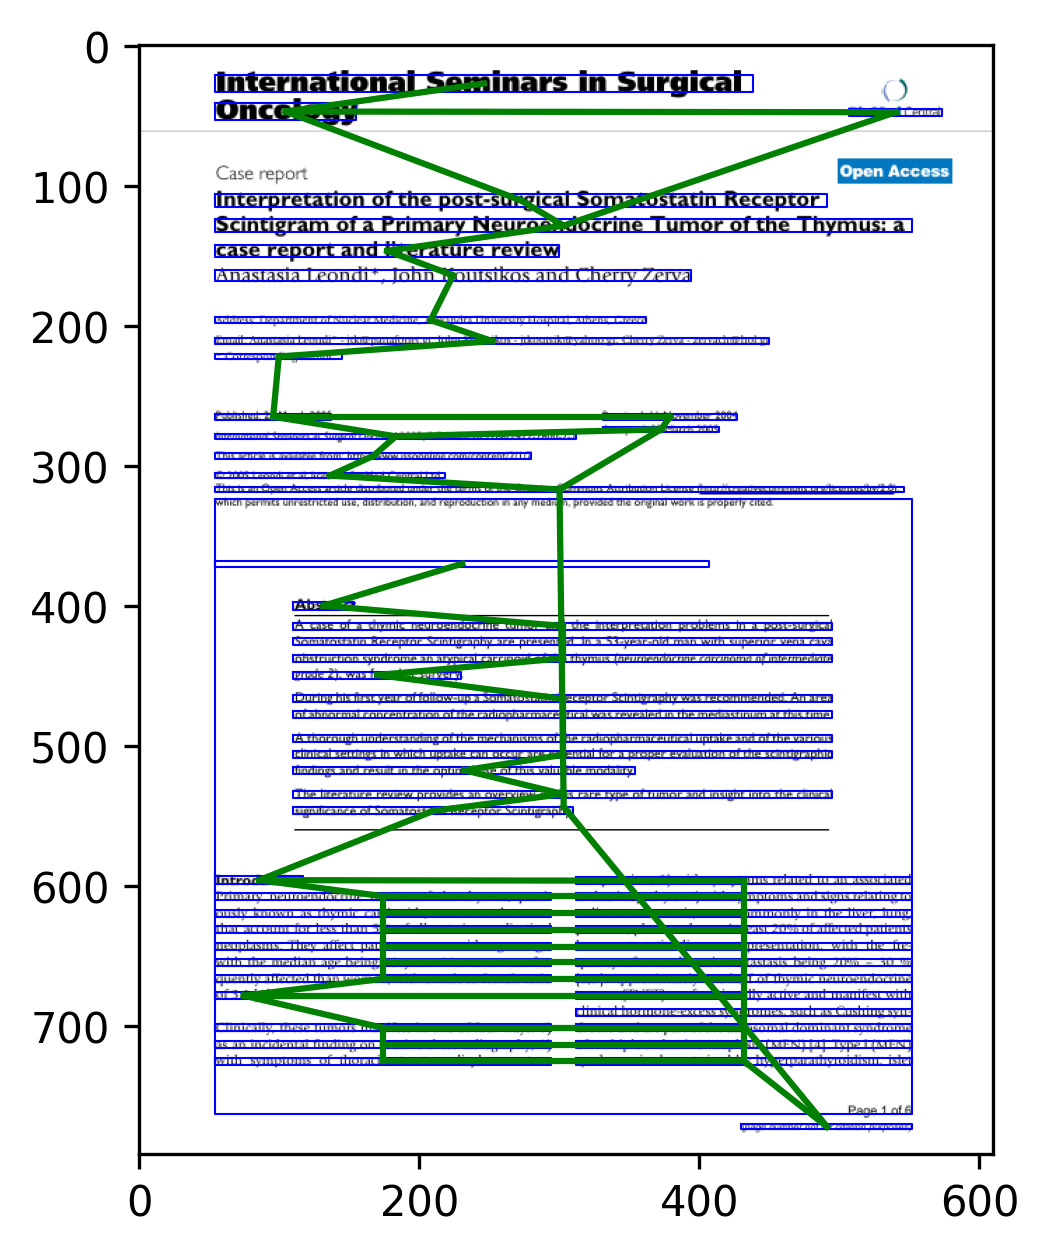

In [85]:
num_file = 2
name_file = files[num_file]
path_pdf = os.path.join(dataset_path, name_file)

pdf.read_from_file(path_pdf, 'r')
pdf2img.convert(pdf, img)

pdf2rows.convert(pdf, rows)
rows_list = rows.to_dict()['rows']
res = tokenizer(rows_list)

fig = plt.figure(dpi=300)
img.show()
ax = plt.gca()

for coords in res["X"]:
    try:
        x0, x1, w, y0, y1, h = coords[:6]
        seg = ImageSegment(int(x0), int(y0), int(x1), int(y1)) 
        seg.plot(width=0.5)
    except:
        continue

A = res['inds']

for i, j in zip(A[0], A[1]):
    x0_0, x1_0, w_0, y0_0, y1_0, h_0 = res["X"][i][:6]
    x0_1, x1_1, w_1, y0_1, y1_1, h_1 = res["X"][j][:6]
    xc1 = (x0_0 + x1_0)/2
    yc1 = (y0_0 + y1_0)/2
    xc2 = (x0_1 + x1_1)/2
    yc2 = (y0_1 + y1_1)/2
    ax.plot([xc1, xc2], [yc1, yc2], 'g')

# ax.set_title(os.path.basename(path_pdf))


In [55]:
res

{'N': 55,
 'X': tensor([[5.0700e+02, 5.7300e+02, 6.6000e+01, 4.5000e+01, 5.0000e+01, 5.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 1.1364e+00, 0.0000e+00],
         [5.4000e+01, 4.3800e+02, 3.8400e+02, 2.1000e+01, 3.3000e+01, 1.2000e+01,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 1.0938e+00, 0.0000e+00],
         [5.4000e+01, 1.5500e+02, 1.0100e+02, 4.1000e+01, 5.3000e+01, 1.2000e+01,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 1.0693e+00, 0.0000e+00],
         [5.4000e+01, 4.9100e+02, 4.3700e+02, 1.0600e+02, 1.1500e+02, 9.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 1.1945e+00, 0.0000e+00],
         [5.4000e+01, 5.5200e+02, 4.9800e+02, 1.2400e+02, 1.3300e+02, 9.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0

# Подготовка датасета

## Torch Dataset

In [86]:
class GLAMDataset(Dataset):
    def __init__(self, json_dir):
        self.json_dir = json_dir
        files  = sorted(os.listdir(self.json_dir))

        if os.path.exists("error_list_file.txt"):
            with open("error_list_file.txt", "r") as f:
                lines = f.readlines()
            error_file = [int(line.split(" ")[0]) for line in lines]
        else:       
            print("TEST OPEN FILE:")
            json_error = []
            key_error = []
            N = len(files)
            for i, file in enumerate(files):
                print(f"{i+1}/{N} ({(i+1)/N*100:.2f} %)" + " "*10, end="\r")
                try:
                    path = os.path.join(self.json_dir, file)
                    with open(path, "r") as f: 
                        j = json.load(f)
                    for k in ["inds", "X", "Y", "N", "true_edges", "true_nodes"]:                    
                        if not k in j:
                            key_error.append(i)
                            raise KeyError(f"{k} not in {file}")
                    if len(j['X']) <= 1 and len(j['Y']) <= 1:
                        raise Exception('one node or one edge')
                except:
                    json_error.append(i)
            
            if len(key_error) != 0:
                print("KEY ERROR FILES:")
                log("KEY ERROR FILES:")
                for i in key_error:
                    print(files[i])
                    log(files[i])

            if len(json_error) != 0:
                print("JSON ERROR FILES:")
                log("JSON ERROR FILES:")
                for i in json_error:
                    print(files[i])
                    log(files[i])
            error_file = sorted(key_error + json_error, reverse=True)
            with open("error_list_file.txt", "w") as f:
                for i in error_file:
                    f.write(str(i) + " "+ files[i] + '\n')
        for i in error_file:
            del files[i]
        self.files = files
        self.count = len(self.files)

        

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        path = os.path.join(self.json_dir, self.files[idx])
        
        with open(path, 'r') as f:
            data = json.load(f)
        data['X'] = torch.tensor(data['X'], dtype=torch.float32)
        data['Y'] = torch.tensor(data['Y'], dtype=torch.float32)
        N = data["N"]
        sp_A = torch.sparse_coo_tensor(indices=data['inds'], values=[1 for e in data["Y"]], size=(N, N), dtype=torch.float32)
        data['sp_A'] = sp_A
        data['true_edges'] = torch.tensor([0 if i is None else i for i in data['true_edges']], dtype=torch.float32)
        if NAME_DATASET == PUBLAYNET:
            data['true_nodes'] = torch.tensor([[1 if c == j else 0 for j in range(1, 6)] 
                                               if c is not None else 
                                               [1, 0, 0, 0, 0] 
                                               for c in data['true_nodes']], dtype=torch.float32)
        
        return data
    
    def __str__(self):
        return f"""DATASET INFO:
count row: {len(self)}
first: {self[0].keys()}
\t A:{np.shape(self[0]["sp_A"])}
\t nodes_feature:{np.shape(self[0]["X"])}
\t edges_feature:{np.shape(self[0]["Y"])}
\t true_edges:{np.shape(self[0]["true_edges"])}
end:{self[-1].keys()}
\t A:{np.shape(self[-1]["sp_A"])}
\t nodes_feature:{np.shape(self[-1]["X"])}
\t edges_feature:{np.shape(self[-1]["Y"])}
\t true_edges:{np.shape(self[-1]["true_edges"])}

"""

# Сохранение датасета

In [57]:
pdfs = [f for f in os.listdir(dataset_path) if f.split('.')[-1] == 'pdf']

class EncodeTensor(JSONEncoder, Dataset):  
    def default(self, obj):
        if isinstance(obj, torch.Tensor):  
            return obj.cpu().detach().numpy().tolist()  
        return super(EncodeTensor, self).default(obj)  

train_data = os.path.join(dataset_path)

# print(pdf_ann)

pdf_ann = get_regions_from_json(coco_path)

os.mkdir(cash_path)
N = len(pdfs)
for i, p in enumerate(pdfs):
    
    try:   
        path_pdf = os.path.join(dataset_path, p)
        
        pdf.read_from_file(path_pdf, 'r')
        pdf2rows.convert(pdf, rows)
        
        
        # Очистка больших строк -----------------------
        H = [r.segment.height for r in rows.rows]
        index = []
        for j, h in enumerate(H):
            H_ = H[:j] + H[j+1:]
            m = np.mean(H_)
            s = np.std(H_)
            if h < m+3*s and h > m-3*s:
                index.append(j)
        rows.rows = [rows.rows[j] for j in index]
        # ---------------------------------------------
        rows_list = rows.to_dict()['rows']
        res = tokenizer(rows_list)
        reg_segments = [ImageSegment(dict_p_size=r['segment']) for r in pdf_ann[p]['regions']]
        reg_categories = [r['category_id'] for r in pdf_ann[p]['regions']]
        true_edges, true_nodes = get_true_edges(res, rows.rows, reg_segments,reg_categories)
        
        del res['sp_A']
        res['true_edges'] = true_edges
        res['true_nodes'] = true_nodes
        name_json = os.path.join(cash_path, p+'.json')
        with open(name_json, 'w') as f:  
            json.dump(res, f, cls=EncodeTensor)  
        print(f"{(i+1)/N*100:4.2f} %", end='\r')
    except:
        pass


FileExistsError: [Errno 17] File exists: '/home/daniil/dataset/PubLayNet/micro_publaynet_10k/tmp/jsons_regions'

# Скрипт обучения

In [87]:
dataset = GLAMDataset(cash_path)

positiv = []
negativ = []

positiv_nodes = []
negativ_nodes = []
k = 0
for g in dataset:
    M = len(g['true_edges'])
    p = sum(g['true_edges'])
    n = M - p
    positiv.append(p)
    negativ.append(n)

    M = len(g['true_nodes'])
    nodes = np.array(g['true_nodes'])
    pp = nodes.sum(axis=0)
    if type(pp) is np.float32:
        continue
    nn = M - pp
    
    positiv_nodes.append(pp)
    negativ_nodes.append(nn)
    

P = np.mean(positiv)
N = np.mean(negativ)
PP = np.mean(positiv_nodes, axis=0)
NN = np.mean(negativ_nodes, axis=0)
disb_nodes = NN/np.power(PP, 0.5)
print(disb_nodes/sum(disb_nodes))
disb = N/P
print(disb)

[0.01007416 0.31603608 0.24261409 0.1461358  0.2851398 ]
1.8131888929945836


In [88]:


def validation(model, batch, criterion):     
    return step(model, batch, optimizer=None, criterion=criterion, train=False)

def split_index_train_val(dataset, val_split=0.2, shuffle=True, seed=1234,batch_size=64):
    N = len(dataset)
    count_batchs = int(N*(1-val_split))//batch_size
    count_val_batch = int(N*(val_split))//batch_size
    train_size = count_batchs * batch_size 
    indexs = [i for i in range(N)]
    if shuffle:
        np.random.shuffle(indexs)
    train_indexs = indexs[:train_size]
    val_indexs = indexs[train_size:]
    batchs_train_indexs = [[train_indexs[k*batch_size+i] for i in range(batch_size)] for k in range(count_batchs)]
    batchs_val_indexs = [[val_indexs[k*batch_size+i] for i in range(batch_size)] for k in range(count_val_batch)]
    return batchs_train_indexs, batchs_val_indexs    

def step(model: torch.nn.Module, batch, optimizer, criterion, train=True):
    if train:
        optimizer.zero_grad()
    my_loss_list = []
   
    for j, data_graph_dict in enumerate(batch):
        try:
            if data_graph_dict is None:
                continue
            pred_graph_dict = model(data_graph_dict)
            loss = criterion(pred_graph_dict, data_graph_dict)
            my_loss_list.append(loss.item())
            print(f"{(j+1)/len(batch)*100:.2f} % Batch loss={my_loss_list[-1]:.4f}" + " "*40, end="\r")
        except Exception as e:
            print(e)
            if "Y" in data_graph_dict.keys():
                print(np.array(data_graph_dict['Y']).shape)
            if "X" in data_graph_dict.keys():
                print(np.array(data_graph_dict['X']).shape)
            continue
        if train:  
            loss.backward()
    if train:
        optimizer.step()
    return np.mean(my_loss_list)

def train_model(params, model, dataset, save_frequency=5, start_epoch=0):  
    optimizer = torch.optim.Adam(
    list(model.parameters()),
    lr=params["learning_rate"],
    )
    criterion = CustomLoss(params["loss_params"]) 

    model.to(device)
    criterion.to(device)

    loss_list = []
    start = time.time()
    train_dataset, val_dataset = split_index_train_val(dataset, val_split=0.1, batch_size=params["batch_size"])
    for k in range(start_epoch, params["epochs"]):
        my_loss_list = []
        if k == start_epoch:
            start = time.time()
        for l, batch_indexs in enumerate(train_dataset):
            batch = [dataset[ind] for ind in batch_indexs]
            batch_loss = step(model, batch, optimizer, criterion)
            my_loss_list.append(batch_loss)
            print(f"Batch # {l+1} loss={my_loss_list[-1]:.4f}" + " "*40)
            if (k == start_epoch and l==0):
                print(f"Время обучения batch'а {time.time()-start:.2f} сек")
        train_val = np.mean(my_loss_list)
        loss_list.append(train_val)

        my_loss_list = []
        for l, batch_indexs in enumerate(val_dataset):
            batch = [dataset[ind] for ind in batch_indexs]
            batch_loss = validation(model, batch, criterion)
            my_loss_list.append(batch_loss)
            print(f"Batch # {l+1} loss={my_loss_list[-1]:.4f}" + " "*40)
        validation_val =  np.mean(my_loss_list)
        print("="*10, f"EPOCH #{k+1}","="*10, f"({train_val:.4f}/{validation_val:.4f})")
        if k == start_epoch:
            print(f"Время обучения epoch {time.time()-start:.2f} сек")    
            
        log(f"EPOCH #{k}\t {train_val:.8f} (VAL: {validation_val:.8f})")  
        if (k+1) % save_frequency == 0:
            num = k//save_frequency
            torch.save(model.state_dict(), GLAM_MODEL+f"_tmp_{num}")
    log(f"Время обучения: {time.time()-start:.2f} сек")
    torch.save(model.state_dict(), GLAM_MODEL)


def load_checkpoint(model, path_model,restart_num=None):
    dir_model = os.path.dirname(path_model)
    name_model = os.path.basename(path_model)
    names = [n for n in os.listdir(dir_model) if name_model+'_tmp_' in n]
    if restart_num is None:
        list_num = [int(n.split("_tmp_")[-1]) for n in names]
        if len(list_num) == 0:
            return
        restart_num = max(list_num) 

    checkpoint_path = os.path.join(dir_model, name_model+f"_tmp_{restart_num}")
    model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    print(checkpoint_path)
    return restart_num



if __name__ == "__main__":
    is_restart = False
    restart_num = None
    dataset = GLAMDataset(cash_path)
    if is_restart:
        log("R E S T A R T ")
    log(datetime.datetime.now().__str__())
    try:
        str_ = dataset.__str__()
        str_ += '\n'.join(f"{key}:\t{val}" for key, val in PARAMS.items())
        print(str_)
        if not is_restart:
            log(str_)
    except:
        print(dataset)
    PARAMS['sigmoidEdge'] = False
    model:torch.nn.Module = TorchModel(PARAMS)
    if is_restart:
        restart_num = load_checkpoint(model, GLAM_MODEL)
    
    start_epoch = 0 if restart_num is None else (restart_num+1)*SAVE_FREQUENCY
    train_model(PARAMS, model, dataset, save_frequency=SAVE_FREQUENCY, start_epoch=start_epoch)

DATASET INFO:
count row: 9305
first: dict_keys(['N', 'X', 'Y', 'inds', 'true_edges', 'true_nodes', 'sp_A'])
	 A:torch.Size([98, 98])
	 nodes_feature:torch.Size([98, 15])
	 edges_feature:torch.Size([140, 4])
	 true_edges:torch.Size([140])
end:dict_keys(['N', 'X', 'Y', 'inds', 'true_edges', 'true_nodes', 'sp_A'])
	 A:torch.Size([40, 40])
	 nodes_feature:torch.Size([40, 15])
	 edges_feature:torch.Size([39, 4])
	 true_edges:torch.Size([39])

node_featch:	15
edge_featch:	4
epochs:	20
batch_size:	50
learning_rate:	0.05
Tag:	[{'in': -1, 'size': 128, 'out': 64, 'k': 3}, {'in': 64, 'size': 64, 'out': 32, 'k': 2}, {'in': 32, 'size': 32, 'out': 16, 'k': 1}]
NodeLinear:	[-1, 16]
NodeLinearClassifier:	[8]
EdgeLinear:	[32, 8]
NodeClasses:	5
batchNormNode:	True
batchNormEdge:	True
seg_k:	0.5
loss_params:	{'publaynet_imbalance': [0.035, 0.107, 0.428, 0.214, 0.214], 'edge_imbalance': 1.87, 'edge_coef': 1, 'node_coef': 0.25}
sigmoidEdge:	False


/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch # 1 loss=1.0528                                        
Время обучения batch'а 0.20 сек
Batch # 2 loss=0.9549                                             
Batch # 3 loss=0.8180                                             
Batch # 4 loss=0.7117                                             
Batch # 5 loss=0.6725                                             
Batch # 6 loss=0.6695                                             
Batch # 7 loss=0.6500                                             
Batch # 8 loss=0.6951                                             
Batch # 9 loss=0.5517                                             
Batch # 10 loss=0.6027                                            
Batch # 11 loss=0.5124                                            
Batch # 12 loss=0.5567                                            
Batch # 13 loss=0.6359                                            
Batch # 14 loss=0.5711                                            
Batch # 15 loss=0.6499             

# Проверка результата

In [98]:
num_file = 5
name_file = files[num_file]
# name_file = 'PMC3050743_00000.pdf'
path_pdf = os.path.join(dataset_path, name_file)
# path_pdf = '/home/daniil/project/PageR/tests/files/text_header_table.pdf'

In [99]:
pdf = PDFModel()
regions = RegionModel()
rows = RowsModel()
img = ImageModel()

pdf2rows = PDF2Rows()
pdf2img = PDF2Img()

PARAMS['sigmoidEdge'] = True
model = TorchModel(PARAMS)
model.load_state_dict(torch.load('./row2region_GLAM', weights_only=True))

rows2regions = Rows2Regions({'model':model, 'tokenizer': RowGLAMTokenizer()})

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


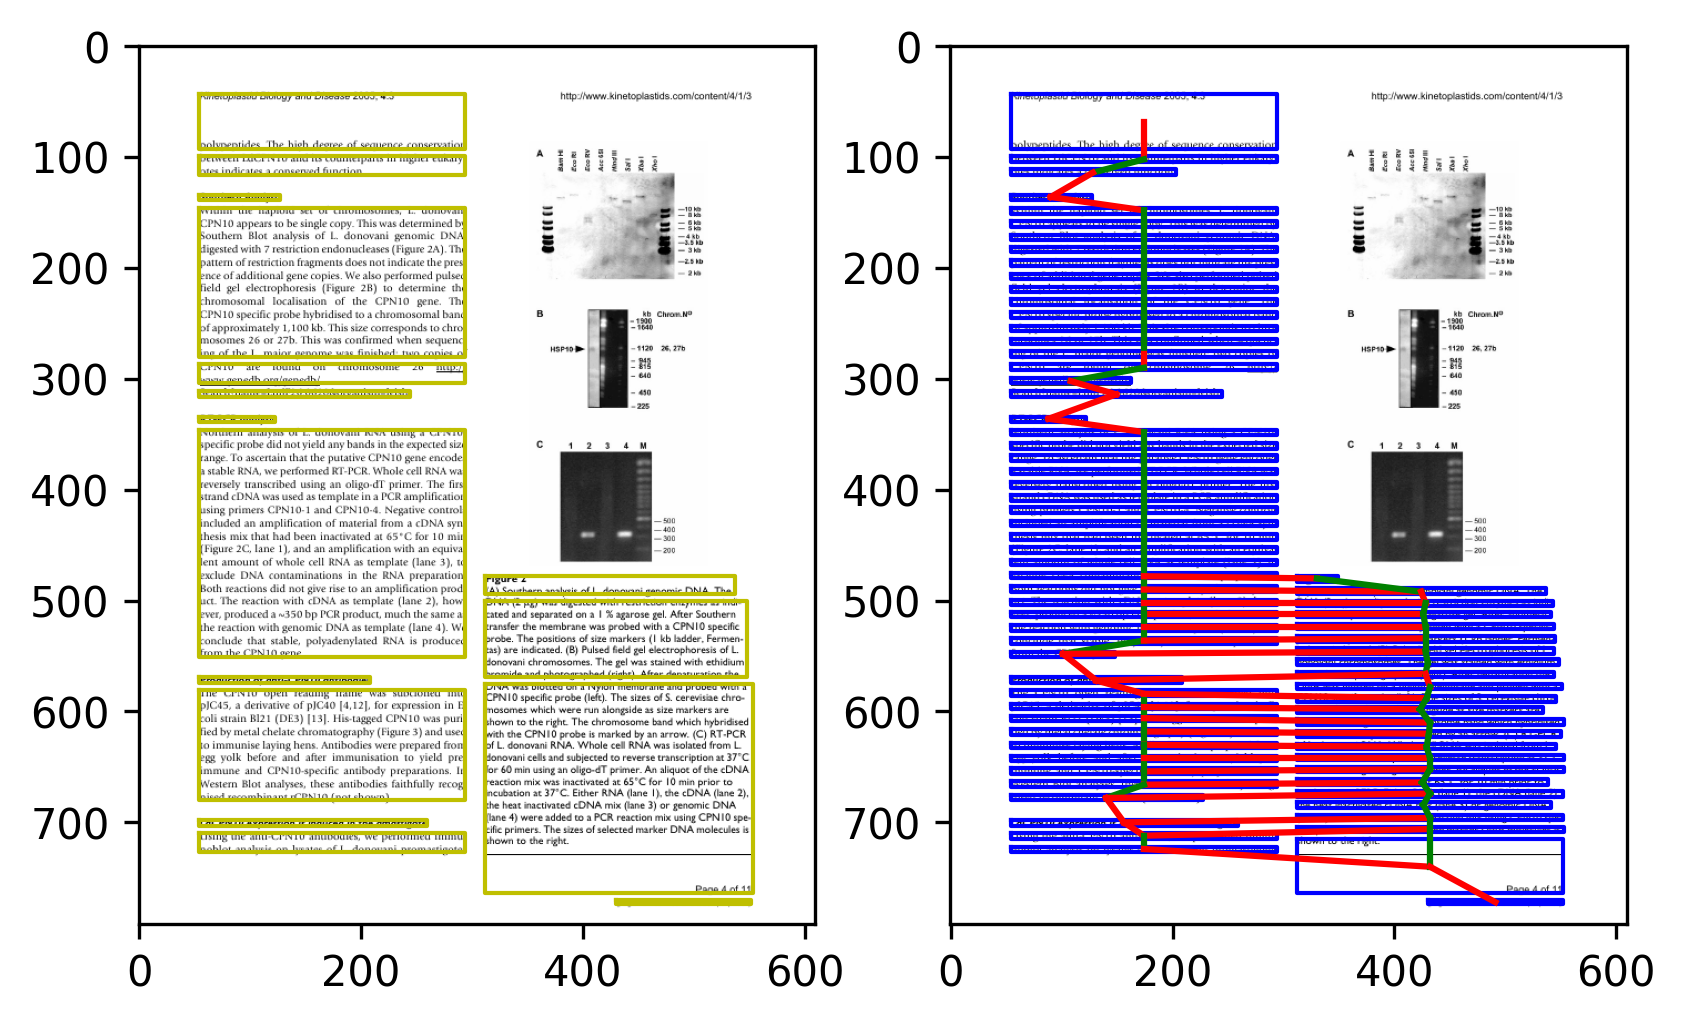

In [100]:
pdf.read_from_file(path_pdf, 'r')
pdf2img.convert(pdf, img)
pdf2rows.convert(pdf, rows)
rows2regions.convert(rows, regions)
plt.figure(dpi=300)
plt.subplot(1, 2, 1)
img.show()
for r in regions.regions:
    r.segment.plot(color='y')

plt.subplot(1, 2, 2)
img.show()
for r in rows.rows:
    r.segment.plot()

tokenizer = RowGLAMTokenizer()
res = tokenizer(rows.to_dict()['rows'])

result = rows2regions.rows2regionsGLAM(res)
result['deleted_edges'] = result['E_pred'] > 0.5

A = res['inds']
E = res['Y']

for i, j, ind in zip(A[0], A[1], result['deleted_edges']):
    w1, w2 = rows.rows[i].segment, rows.rows[j].segment
    x1, y1 = w1.get_center()
    x2, y2 = w2.get_center()
    plt.plot([x1, x2], [y1, y2], 'g' if ind < 0.5 else 'r')

In [102]:
# result['node_classes']

# Тестирование

In [103]:
ann = get_regions_from_json(test_coco_path)

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def update_regions(an_regions:list[ImageSegment], regions:list[ImageSegment]):
    new_regs = []
    for an_r in an_regions:
        intersec = [r for r in regions if an_r.is_intersection(r)]
        new_regs.append(intersec[0] if len(intersec) == 1 else an_r)
    return new_regs
    
COUNT_TEST_SIZE = 100

def get_bbox(seg:ImageSegment, resize = None, delta_w = 0, delta_h = 0):
    coef_w, coef_h = 1, 1
    if resize:
        coef_w, coef_h = resize
        
    segment = seg.get_segment_2p()
    if not 'width' in segment:
        segment['width'] = segment['x_bottom_right']-segment['x_top_left']
        segment['height'] = segment['y_bottom_right']-segment['y_top_left']
    return [
        int(coef_w*segment['x_top_left']-delta_w),
        int(coef_h*segment['y_top_left']-delta_h),
        int(coef_w*segment['width']+delta_w),
        int(coef_h*segment['height']+delta_h)
    ]

def get_category(dict_region):
    # category_id = dict_region['category_id']
    return 1

# test_delta = [{'w': j, 'h': i} for i in range(6) for j in range(6)]
# map_res = []

# for delts in test_delta:
target = []
preds = []
paths = []
i = 0
for file_name, true_regions in ann.items():
    i += 1
    try:
        path_file = os.path.join(test_path, file_name)
        paths.append(path_file)
        pdf.read_from_file(path_file, 'r')
        pdf2rows.convert(pdf, rows)
        rows2regions.convert(rows, regions)
    
        # doclaynet 1024x1024 img -----------------------------------------------------
        if NAME_DATASET == DOCLAYNET:
            w, h = pdf.pdf_json['pages'][0]['width'],pdf.pdf_json['pages'][0]['height']
            coef_w, coef_h = w/1024, h/1024
        elif NAME_DATASET == PUBLAYNET:
            coef_w, coef_h = 1, 1
        else:
            raise Exception('Проверить соотношение сторон')
        # -----------------------------------------------------------------------------
    
        regions_ = [r.segment for r in regions.regions]
        an_regions = [ImageSegment(dict_p_size={
            "x_top_left": int(r['segment']['x_top_left']*coef_w),
            "y_top_left": int(r['segment']['y_top_left']*coef_h),
            "width": int(r['segment']['width']*coef_w),
            "height": int(r['segment']['height']*coef_h)
                                                }) for r in true_regions['regions']]
        # an_regions = update_regions(an_regions_, regions_)
        
        true_res = dict(     
                boxes=torch.tensor([get_bbox(an) for an in  an_regions]) ,
                labels=torch.tensor([get_category(an) for an in an_regions]),
                )
        pred_res = dict(     
                boxes=torch.tensor([get_bbox(an, delta_h=4, delta_w=0) for an in  regions_]) ,
                scores=torch.tensor([1.0 for an in regions_]),
                labels=torch.tensor([get_category(an) for an in regions_]),
                )
        target.append(true_res)
        preds.append(pred_res)
    except:
        pass
    
    if i > COUNT_TEST_SIZE:
        break
        
    
metric = MeanAveragePrecision(box_format="xywh")
metric.update(preds, target)  
rez = metric.compute()
    # map_res.append(rez['map'])

print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/pro

In [31]:
# ind_ = int(torch.argmax(torch.tensor(map_res)))
# test_delta[ind_]

{'w': 0, 'h': 4}

Наших: 9 Разметка: 8
mAP@IoU[0.50:0.95] = 0.27510607


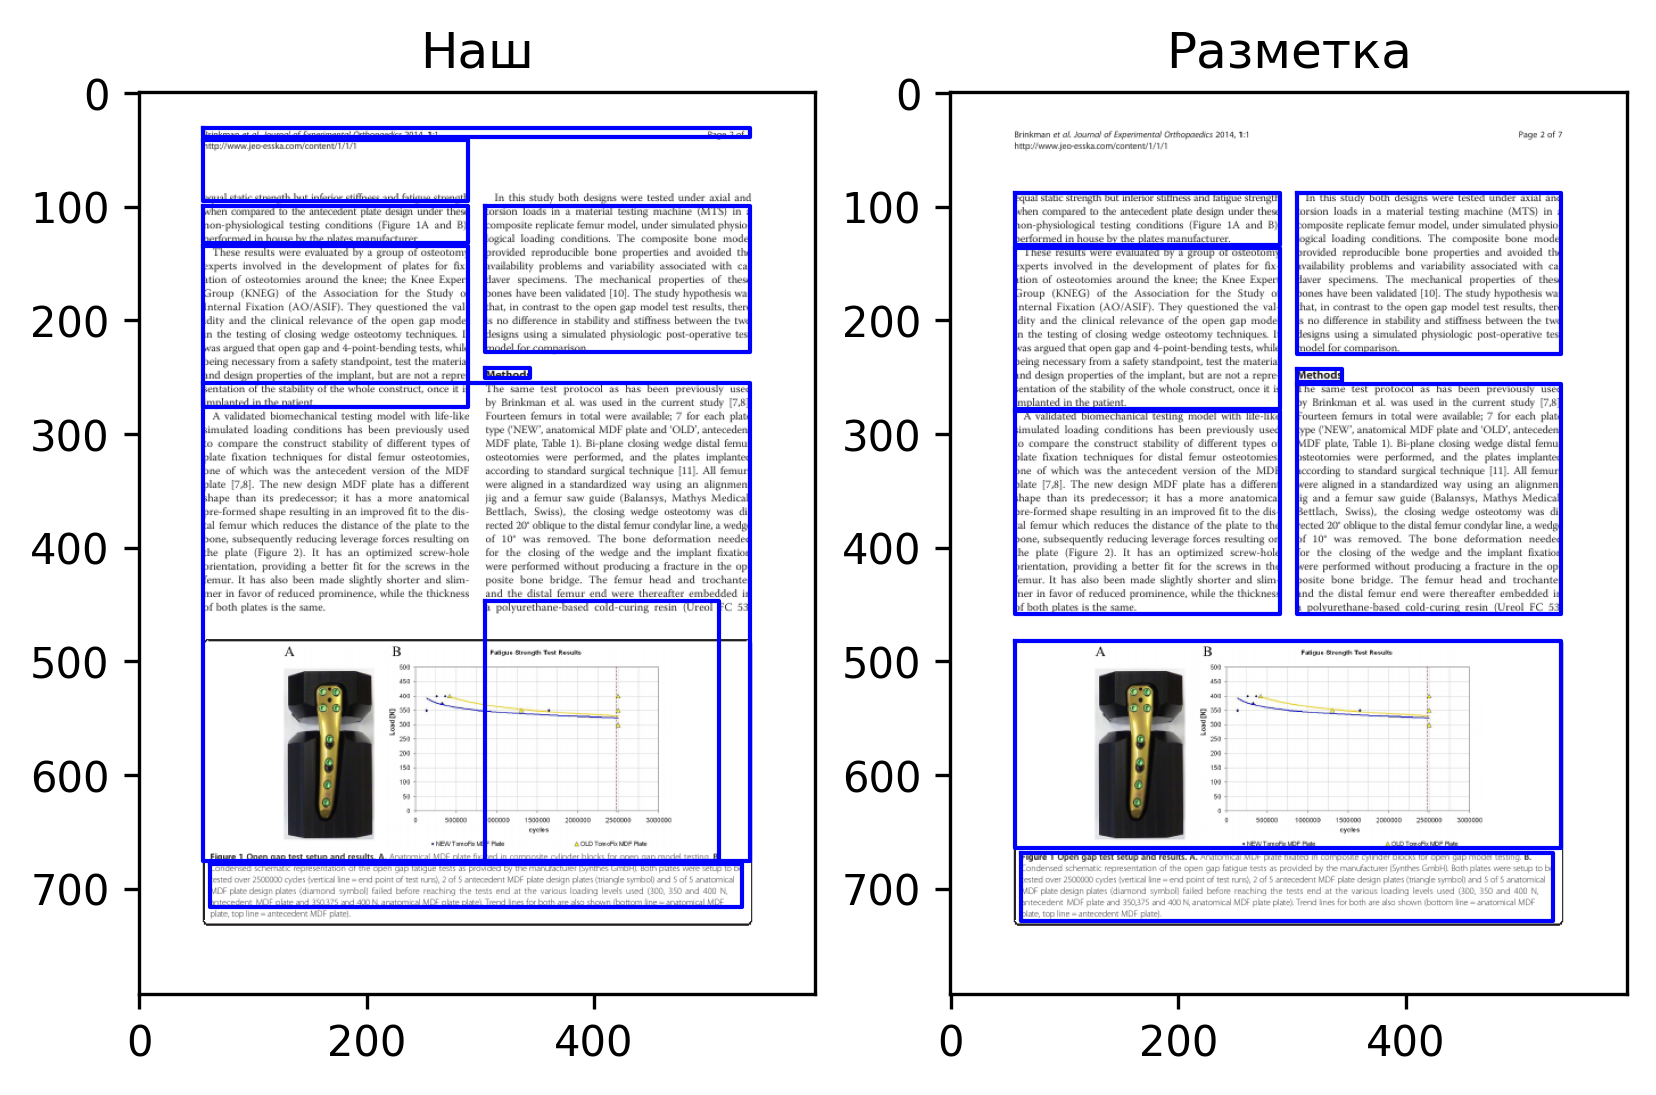

In [38]:
i = 12
tr = target[i]
pr = preds[i]
file = paths[i]

plt.figure(dpi=300)

plt.subplot(1, 2, 1)
pdf.read_from_file(file, 'r')
pdf2img.convert(pdf, img)
img.show()
for reg in pr['boxes']:
    
    x0 = reg[0]
    y0 = reg[1]
    w = reg[2]
    h = reg[3]
    s = ImageSegment(x0, y0, x0+w, y0+h)
    s.plot()
plt.title('Наш')


plt.subplot(1, 2, 2)
img.show()
for reg in tr['boxes']:
    
    x0 = reg[0]
    y0 = reg[1]
    w = reg[2]
    h = reg[3]
    s = ImageSegment(x0, y0, x0+w, y0+h)
    s.plot()
plt.title('Разметка')
metric = MeanAveragePrecision(box_format="xywh")
metric.update([preds[i]], [target[i]])  
rez = metric.compute()
# map_res.append(rez['map'])
print(f'Наших: {len(pr['boxes'])}', f'Разметка: {len(tr['boxes'])}')
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

### 

In [310]:
# import os
# import glob
# import json
# import matplotlib.patches as patches
# import matplotlib.pyplot as plt
# from IPython.display import display, clear_output  # <-- добавлено
# plt.close(fig)

# pdf_dir = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/pdfs/dev/'
# pdf_paths = sorted(glob.glob(os.path.join(pdf_dir, '*.pdf')))

# for path_pdf in pdf_paths[:20]:
#     pdf.read_from_file(path_pdf, 'r')
#     pdf2img.convert(pdf, img)
#     pdf2rows.convert(pdf, rows)
#     rows2regions.convert(rows, regions)
    
#     fig = plt.figure(dpi=300)
#     img.show()
#     for r in regions.regions:
#         r.segment.plot()
    
#     display(fig)
#     plt.close(fig)


# Доразметка

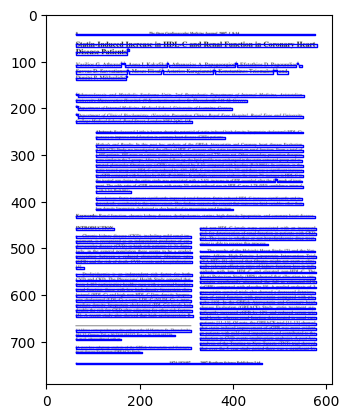

In [294]:
name_file = 'PMC2570568_00000.pdf'

path_pdf = os.path.join(dataset_path, name_file)
pdf.read_from_file(path_pdf, 'r')
pdf2img.convert(pdf, img)
pdf2rows.convert(pdf, rows)
img.show()
for row in rows.rows:
    row.segment.plot()

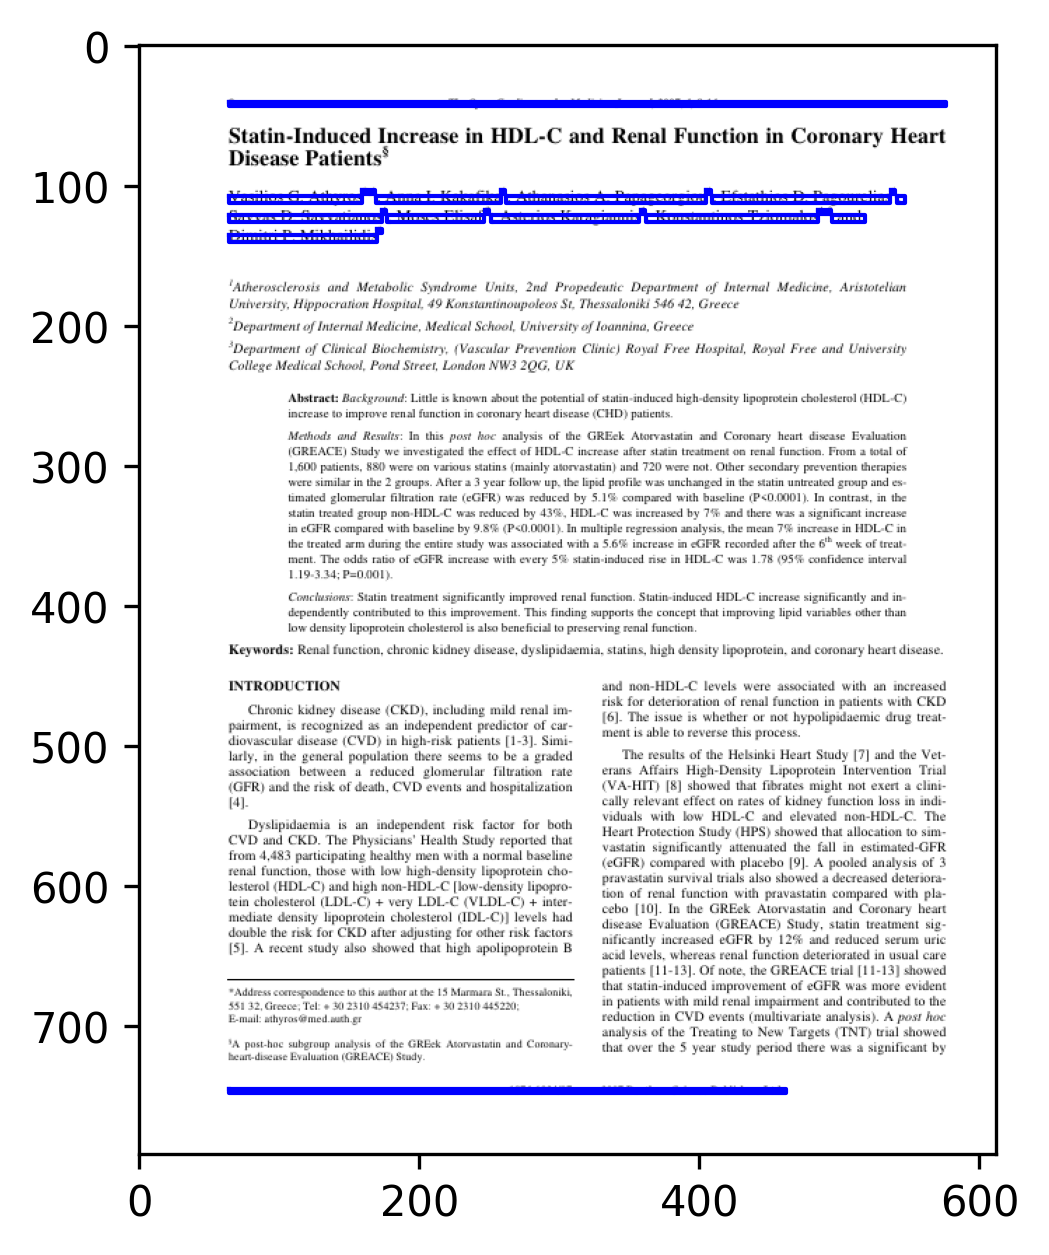

In [295]:
plt.figure(dpi=300)
img.show()

regions = [ImageSegment(dict_p_size=an['segment']) for an in pdf_ann['PMC2570568_00000.pdf']['regions']]
def is_into_region(seg, regions):
    for seg in regions:
        if row.segment.is_intersection(seg):
            return True
    return False


for row in rows.rows:
    if not is_into_region(row.segment, regions):
        row.segment.plot()
            

# Тест метрики

In [32]:
metric = MeanAveragePrecision(box_format="xywh")

true_res_i = dict(     
        boxes=torch.tensor([[0, 0, 11, 10]]) , # 10% ошибка в одном блоке
        labels=torch.tensor([1]),
                )
pred_res_j = dict(     
        boxes=torch.tensor([[0, 0, 10, 10] ]) ,
        scores=torch.tensor([1.0]),
        labels=torch.tensor([1]),
        )
metric.update([pred_res_j], [true_res_i]) 
rez = metric.compute()
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

mAP@IoU[0.50:0.95] = 0.89999998


In [33]:
metric = MeanAveragePrecision(box_format="xywh")

true_res_i = dict(     
        boxes=torch.tensor([[0, 0, 10, 10], [20, 20, 21, 21]]) ,
        labels=torch.tensor([1, 1]),
                )
pred_res_j = dict(     
        boxes=torch.tensor([[0, 0, 10, 10] ]) ,
        scores=torch.tensor([1.0]),
        labels=torch.tensor([1]),
        )
metric.update([pred_res_j], [true_res_i]) 
rez = metric.compute()
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

mAP@IoU[0.50:0.95] = 0.50495052


In [34]:
metric = MeanAveragePrecision(box_format="xywh")

true_res_i = dict(     
        boxes=torch.tensor([[0, 0, 10, 10]]) ,
        labels=torch.tensor([1]),
                )
pred_res_j = dict(     
        boxes=torch.tensor([[0, 0, 10, 10], [20, 20, 21, 21]]) ,
        scores=torch.tensor([1.0, 1.0]),
        labels=torch.tensor([1, 1]),
        )
metric.update([pred_res_j], [true_res_i]) 
rez = metric.compute()
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

mAP@IoU[0.50:0.95] = 1.00000000


In [35]:
metric = MeanAveragePrecision(box_format="xywh")

N = 3
true_blocks = [[0+i*10, 10+i*10, 10, 10]  for i in range(N+1)]
pred_blocks = [[0+i*10+1, 10+i*10, 10-2, 10]  for i in range(N)] # слева и справа 10% и у 10 блоков 
                                                                  # и вся метрика падает на 60 %

true_res_i = dict(     
        boxes=torch.tensor(true_blocks) ,
        labels=torch.tensor([1 for i in true_blocks]),
                )
pred_res_j = dict(     
        boxes=torch.tensor(pred_blocks), 

        scores=torch.tensor([0.01 for i in pred_blocks]),
        labels=torch.tensor([1 for i in pred_blocks]),
        )
tb = [true_res_i]
pb = [pred_res_j]

metric.update(pb, tb) 
rez = metric.compute()
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

mAP@IoU[0.50:0.95] = 0.45148516


Text(0.5, 1.0, 'mAP@IoU[0.50:0.95] = 0.45148516')

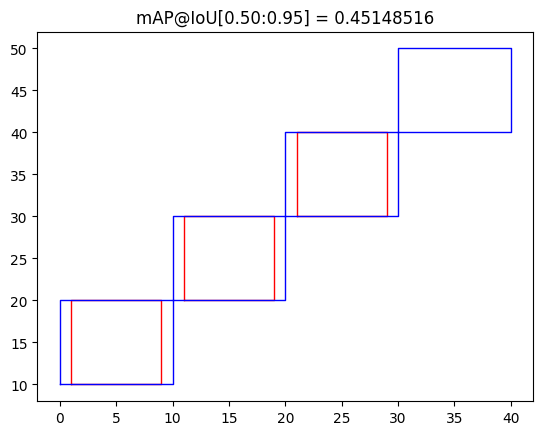

In [36]:
tr = tb[0]
pr = pb[0]

for reg in pr['boxes']:
    
    x0 = reg[0]
    y0 = reg[1]
    w = reg[2]
    h = reg[3]
    s = ImageSegment(x0, y0, x0+w, y0+h)
    s.plot(color='r')

for reg in tr['boxes']:
    
    x0 = reg[0]
    y0 = reg[1]
    w = reg[2]
    h = reg[3]
    s = ImageSegment(x0, y0, x0+w, y0+h)
    s.plot()
plt.title(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")


In [37]:
metric = MeanAveragePrecision(box_format="xywh")

N = 3
true_blocks = [[0+i*10, 10+i*10, 10, 10]  for i in range(N+1)]
pred_blocks = [[0+i*10-1, 10+i*10, 10+2, 10]  for i in range(N)] # слева и справа 10% и у 10 блоков 
                                                                  # и вся метрика падает на 60 %

true_res_i = dict(     
        boxes=torch.tensor(true_blocks) ,
        labels=torch.tensor([1 for i in true_blocks]),
                )
pred_res_j = dict(     
        boxes=torch.tensor(pred_blocks), 

        scores=torch.tensor([1.0 for i in pred_blocks]),
        labels=torch.tensor([1 for i in pred_blocks]),
        )
tb = [true_res_i]
pb = [pred_res_j]

metric.update(pb, tb) 
rez = metric.compute()
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

mAP@IoU[0.50:0.95] = 0.52673268


In [39]:
metric = MeanAveragePrecision(box_format="xywh")

N = 3

true_blocks = [[0+i*10, 10+i*10, 10, 10]  for i in range(N+1)]
pred_blocks = [[0+i*10-1, 10+i*10, 10+2, 10]  for i in range(N)] # слева и справа 10% и у 10 блоков 
                                                                  # и вся метрика падает на 60 %

true_res_i = dict(     
        boxes=torch.tensor(true_blocks) ,
        labels=torch.tensor([1 for i in true_blocks]),
                )
pred_res_j = dict(     
        boxes=torch.tensor(pred_blocks), 

        scores=torch.tensor([1.0 for i in pred_blocks]),
        labels=torch.tensor([1 for i in pred_blocks]),
        )
tb = [ true_res_i]
pb = [ pred_res_j]

metric.update(pb, tb) 
rez = metric.compute()
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

mAP@IoU[0.50:0.95] = 0.72376239


In [110]:
metric = MeanAveragePrecision(box_format="xywh")
true_detect_block = [[0+i*10, 10+i*10, 6, 6]  for i in range(0)]

M1 = 3
M2 = 0
true_unic_block = [[100+i*10, 0, 6, 6] for i in range(M1)]
pred_unic_block = [[110+i*10, 10, 6, 6] for i in range(M2)]

N = 4
blockN = [[10*i, 100, 10, 10] for i in range(N)]
blockNin1 = [[0, 100, N*10, 10]]

true_ = true_detect_block + true_unic_block + blockN
pred_ = true_detect_block + pred_unic_block + blockNin1

true_res_i = dict(     
        boxes=torch.tensor(true_) ,
        labels=torch.tensor([1 for i in true_]),
                )
pred_res_j = dict(     
        boxes=torch.tensor(pred_), 

        scores=torch.tensor([1.0 for i in pred_]),
        labels=torch.tensor([1 for i in pred_]),
        )

tb = [ true_res_i]
pb = [ pred_res_j]
metric = MeanAveragePrecision(box_format="xywh")
metric.update(pb, tb) 
rez = metric.compute()
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

mAP@IoU[0.50:0.95] = 0.00000000


Text(0.5, 1.0, 'mAP@IoU[0.50:0.95] = 0.00000000')

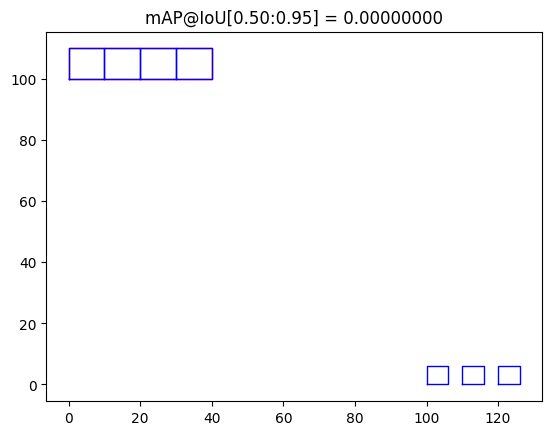

In [111]:
tr = tb[0]
pr = pb[0]

for reg in pr['boxes']:
    
    x0 = reg[0]
    y0 = reg[1]
    w = reg[2]
    h = reg[3]
    s = ImageSegment(x0, y0, x0+w, y0+h)
    s.plot(color='r')

for reg in tr['boxes']:
    
    x0 = reg[0]
    y0 = reg[1]
    w = reg[2]
    h = reg[3]
    s = ImageSegment(x0, y0, x0+w, y0+h)
    s.plot()
plt.title(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")